# Self-Training với Nhiều Ngưỡng τ - Thí Nghiệm So Sánh

## Mục tiêu
- Chạy self-training với **nhiều giá trị ngưỡng τ khác nhau** (0.70, 0.80, 0.85, 0.90, 0.95)
- So sánh diễn biến qua các vòng lặp
- Phân tích số lượng pseudo-labels được thêm mỗi vòng
- Quan sát validation accuracy/F1-macro qua các vòng
- So sánh kết quả test với baseline
- Chọn ngưỡng τ tối ưu

## Giải thích Ngưỡng τ

**Ngưỡng τ (tau)** là độ tin cậy tối thiểu mà mô hình cần đạt được khi dự đoán.

### Ví dụ đơn giản:
Giả sử bạn là giáo viên chấm bài thi trắc nghiệm:
- **Học sinh A** chọn đáp án B và nói: "Em chắc chắn 95% là đáp án B"
- **Học sinh B** chọn đáp án C và nói: "Em đoán thôi, khoảng 60% là đáp án C"

Nếu bạn đặt ngưỡng τ = 0.90:
- ✅ Học sinh A (95% ≥ 90%) → BẠN TIN và dùng câu trả lời này
- ❌ Học sinh B (60% < 90%) → BẠN KHÔNG TIN và bỏ qua

Tương tự, trong self-training:
- Mô hình dự đoán nhiều mẫu chưa có nhãn
- Chỉ những dự đoán có độ tin cậy ≥ τ mới được chấp nhận làm "nhãn giả"
- Những nhãn giả này được thêm vào tập train để train tiếp

In [1]:
# PARAMETERS - Có thể điều chỉnh
SEMI_DATASET_PATH = "data/processed/dataset_for_semi.parquet"
CUTOFF = "2017-01-01"

# Danh sách các giá trị TAU để thử nghiệm
TAU_VALUES = [0.70, 0.80, 0.85, 0.90, 0.95]

# Các tham số cố định
MAX_ITER = 10
MIN_NEW_PER_ITER = 20
VAL_FRAC = 0.20
RANDOM_STATE = 42

# Output paths
RESULTS_DIR = "data/processed/self_training_experiments"
ALERT_FROM_CLASS = "Unhealthy"

In [2]:
# Parameters
SEMI_DATASET_PATH = "data/processed/dataset_for_semi.parquet"
CUTOFF = "2017-01-01"
TAU_VALUES = [0.8, 0.9, 0.95]
MAX_ITER = 10
MIN_NEW_PER_ITER = 20
VAL_FRAC = 0.2
RANDOM_STATE = 42
RESULTS_DIR = "data/processed/self_training_experiments"
ALERT_FROM_CLASS = "Unhealthy"


In [3]:
from pathlib import Path
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown

from src.semi_supervised_library import (
    SemiDataConfig, SelfTrainingConfig, run_self_training, add_alert_columns
)

# Setup paths
PROJECT_ROOT = Path(".").resolve()
if not (PROJECT_ROOT / "data").exists() and (PROJECT_ROOT.parent / "data").exists():
    PROJECT_ROOT = PROJECT_ROOT.parent.resolve()

results_dir = (PROJECT_ROOT / RESULTS_DIR).resolve()
results_dir.mkdir(parents=True, exist_ok=True)

print(f"Project root: {PROJECT_ROOT}")
print(f"Results directory: {results_dir}")

Project root: D:\DataEngineer\DataMining\air_guard_mini_project
Results directory: D:\DataEngineer\DataMining\air_guard_mini_project\data\processed\self_training_experiments


## Bước 1: Load Dataset và Kiểm Tra Tỉ Lệ Labeled/Unlabeled

In [4]:
# Load dataset
df = pd.read_parquet((PROJECT_ROOT / SEMI_DATASET_PATH).resolve())

print("Dataset shape:", df.shape)
print("\nColumns:", df.columns.tolist())

# Check labeled ratio
if "is_labeled" in df.columns:
    labeled_ratio = df["is_labeled"].mean()
    print(f"\nLabeled ratio: {labeled_ratio:.2%}")
    print(f"Labeled samples: {df['is_labeled'].sum():,}")
    print(f"Unlabeled samples: {(~df['is_labeled']).sum():,}")
else:
    print("\nWarning: 'is_labeled' column not found")

# Check train/test split
train_mask = df["datetime"] < pd.Timestamp(CUTOFF)
test_mask = df["datetime"] >= pd.Timestamp(CUTOFF)

print(f"\nTrain samples: {train_mask.sum():,}")
print(f"Test samples: {test_mask.sum():,}")

if "is_labeled" in df.columns:
    print(f"\nTrain labeled: {(train_mask & df['is_labeled']).sum():,}")
    print(f"Train unlabeled: {(train_mask & ~df['is_labeled']).sum():,}")

df.head()

Dataset shape: (420768, 56)

Columns: ['No', 'year', 'month', 'day', 'hour', 'PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'wd', 'WSPM', 'station', 'datetime', 'pm25_24h', 'aqi_class', 'hour_sin', 'hour_cos', 'dow', 'is_weekend', 'PM10_lag1', 'SO2_lag1', 'NO2_lag1', 'CO_lag1', 'O3_lag1', 'TEMP_lag1', 'PRES_lag1', 'DEWP_lag1', 'RAIN_lag1', 'WSPM_lag1', 'PM10_lag3', 'SO2_lag3', 'NO2_lag3', 'CO_lag3', 'O3_lag3', 'TEMP_lag3', 'PRES_lag3', 'DEWP_lag3', 'RAIN_lag3', 'WSPM_lag3', 'PM10_lag24', 'SO2_lag24', 'NO2_lag24', 'CO_lag24', 'O3_lag24', 'TEMP_lag24', 'PRES_lag24', 'DEWP_lag24', 'RAIN_lag24', 'WSPM_lag24', 'is_labeled']

Labeled ratio: 8.67%
Labeled samples: 36,485
Unlabeled samples: 384,283

Train samples: 403,776
Test samples: 16,992

Train labeled: 19,814
Train unlabeled: 383,962


,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,...,SO2_lag24,NO2_lag24,CO_lag24,O3_lag24,TEMP_lag24,PRES_lag24,DEWP_lag24,RAIN_lag24,WSPM_lag24,is_labeled
0,1,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,2,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,3,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,4,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,5,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


## Bước 2: Chạy Self-Training với Nhiều Giá Trị τ

### Giải thích quy trình:
```
Với mỗi giá trị τ:
  Vòng 1:
    1. Train model trên labeled data (5%)
    2. Dự đoán trên unlabeled data (95%)
    3. Chọn những dự đoán có confidence ≥ τ
    4. Thêm vào labeled data
  
  Vòng 2:
    1. Train model trên labeled data mở rộng
    2. Dự đoán trên unlabeled còn lại
    3. Chọn những dự đoán có confidence ≥ τ
    4. Thêm vào labeled data
  
  ... lặp lại cho đến khi:
    - Không còn đủ pseudo-labels confident
    - Hoặc đạt max_iter
```

In [5]:
# Dictionary để lưu kết quả từng tau
all_results = {}

data_cfg = SemiDataConfig(cutoff=CUTOFF, random_state=RANDOM_STATE)

for tau in TAU_VALUES:
    print(f"\n{'='*60}")
    print(f"Running Self-Training with TAU = {tau}")
    print(f"{'='*60}")
    
    st_cfg = SelfTrainingConfig(
        tau=tau,
        max_iter=MAX_ITER,
        min_new_per_iter=MIN_NEW_PER_ITER,
        val_frac=VAL_FRAC,
    )
    
    # Run self-training
    out = run_self_training(df.copy(), data_cfg, st_cfg)
    
    history = pd.DataFrame(out["history"])
    test_metrics = out["test_metrics"]
    pred_df = out["pred_df"]
    
    # Display history
    print("\nTraining History:")
    display(history)
    
    print(f"\nTest Accuracy: {test_metrics['accuracy']:.4f}")
    print(f"Test F1-macro: {test_metrics['f1_macro']:.4f}")
    
    # Save results
    tau_str = str(tau).replace('.', '_')
    
    # Save metrics
    metrics_path = results_dir / f"metrics_tau_{tau_str}.json"
    payload = {
        "method": "self_training",
        "tau": tau,
        "data_cfg": data_cfg.__dict__,
        "st_cfg": st_cfg.__dict__,
        "history": out["history"],
        "test_metrics": test_metrics,
        "model_info": out["model_info"],
    }
    with open(metrics_path, "w", encoding="utf-8") as f:
        json.dump(payload, f, ensure_ascii=False, indent=2)
    
    # Save predictions
    pred_path = results_dir / f"predictions_tau_{tau_str}.csv"
    pred_df.to_csv(pred_path, index=False)
    
    # Save to memory for comparison
    all_results[tau] = {
        "history": history,
        "test_metrics": test_metrics,
        "pred_df": pred_df,
    }
    
    print(f"\n✓ Saved: {metrics_path}")
    print(f"✓ Saved: {pred_path}")

print(f"\n{'='*60}")
print("All experiments completed!")
print(f"{'='*60}")


Running Self-Training with TAU = 0.8



Training History:


,iter,val_accuracy,val_f1_macro,unlabeled_pool,new_pseudo,tau
0,1,0.722615,0.679270,383962,154115,0.8
1,2,0.708228,0.675047,229847,166298,0.8
2,3,0.701918,0.666222,63549,27129,0.8
3,4,0.703180,0.666744,36420,7686,0.8
4,5,0.699142,0.659539,28734,3512,0.8
5,6,0.690560,0.650806,25222,1575,0.8
6,7,0.700151,0.662619,23647,1487,0.8
7,8,0.700404,0.666110,22160,1041,0.8
8,9,0.695103,0.657425,21119,823,0.8
9,10,0.697627,0.662147,20296,722,0.8



Test Accuracy: 0.5941
Test F1-macro: 0.5167

✓ Saved: D:\DataEngineer\DataMining\air_guard_mini_project\data\processed\self_training_experiments\metrics_tau_0_8.json
✓ Saved: D:\DataEngineer\DataMining\air_guard_mini_project\data\processed\self_training_experiments\predictions_tau_0_8.csv

Running Self-Training with TAU = 0.9



Training History:


,iter,val_accuracy,val_f1_macro,unlabeled_pool,new_pseudo,tau
0,1,0.722615,0.679270,383962,76134,0.9
1,2,0.713781,0.678319,307828,202713,0.9
2,3,0.706461,0.672945,105115,45622,0.9
3,4,0.700151,0.665001,59493,12716,0.9
4,5,0.695356,0.655768,46777,5519,0.9
5,6,0.670116,0.624643,41258,1660,0.9
6,7,0.690056,0.650048,39598,2953,0.9
7,8,0.663806,0.612969,36645,587,0.9
8,9,0.701161,0.664477,36058,1762,0.9
9,10,0.666835,0.617609,34296,353,0.9



Test Accuracy: 0.5890
Test F1-macro: 0.5343

✓ Saved: D:\DataEngineer\DataMining\air_guard_mini_project\data\processed\self_training_experiments\metrics_tau_0_9.json
✓ Saved: D:\DataEngineer\DataMining\air_guard_mini_project\data\processed\self_training_experiments\predictions_tau_0_9.csv

Running Self-Training with TAU = 0.95



Training History:


,iter,val_accuracy,val_f1_macro,unlabeled_pool,new_pseudo,tau
0,1,0.722615,0.679270,383962,32943,0.95
1,2,0.718576,0.676012,351019,185529,0.95
2,3,0.708481,0.664617,165490,74534,0.95
3,4,0.650934,0.602460,90956,10241,0.95
4,5,0.659263,0.610434,80715,5497,0.95
5,6,0.648410,0.596585,75218,1656,0.95
6,7,0.656991,0.605293,73562,1947,0.95
7,8,0.651691,0.605680,71615,1071,0.95
8,9,0.650681,0.600152,70544,827,0.95
9,10,0.646138,0.594974,69717,589,0.95



Test Accuracy: 0.5931
Test F1-macro: 0.5330

✓ Saved: D:\DataEngineer\DataMining\air_guard_mini_project\data\processed\self_training_experiments\metrics_tau_0_95.json
✓ Saved: D:\DataEngineer\DataMining\air_guard_mini_project\data\processed\self_training_experiments\predictions_tau_0_95.csv

All experiments completed!


## Bước 3: So Sánh Kết Quả Test với Các Giá Trị τ Khác Nhau

In [6]:
# Tạo bảng so sánh
comparison_data = []

for tau in TAU_VALUES:
    metrics = all_results[tau]["test_metrics"]
    history = all_results[tau]["history"]
    
    comparison_data.append({
        "TAU (τ)": tau,
        "Test Accuracy": metrics["accuracy"],
        "Test F1-macro": metrics["f1_macro"],
        "Số vòng lặp": len(history),
        "Tổng pseudo-labels": history["new_pseudo"].sum(),
        "Val F1 cuối": history["val_f1_macro"].iloc[-1],
    })

comparison_df = pd.DataFrame(comparison_data)

print("\n" + "="*80)
print("BẢNG SO SÁNH KẾT QUẢ CÁC GIÁ TRỊ τ")
print("="*80)
display(comparison_df)

# Highlight best results
best_acc_idx = comparison_df["Test Accuracy"].idxmax()
best_f1_idx = comparison_df["Test F1-macro"].idxmax()

print("\n📊 KẾT QUẢ TỐT NHẤT:")
print(f"- Accuracy cao nhất: τ = {comparison_df.loc[best_acc_idx, 'TAU (τ)']} → {comparison_df.loc[best_acc_idx, 'Test Accuracy']:.4f}")
print(f"- F1-macro cao nhất: τ = {comparison_df.loc[best_f1_idx, 'TAU (τ)']} → {comparison_df.loc[best_f1_idx, 'Test F1-macro']:.4f}")

# Save comparison
comparison_path = results_dir / "comparison_summary.csv"
comparison_df.to_csv(comparison_path, index=False)
print(f"\n✓ Saved: {comparison_path}")


BẢNG SO SÁNH KẾT QUẢ CÁC GIÁ TRỊ τ


,TAU (τ),Test Accuracy,Test F1-macro,Số vòng lặp,Tổng pseudo-labels,Val F1 cuối
0,0.80,0.594086,0.516688,10,364388,0.662147
1,0.90,0.589047,0.534326,10,350019,0.617609
2,0.95,0.593066,0.532986,10,314834,0.594974



📊 KẾT QUẢ TỐT NHẤT:
- Accuracy cao nhất: τ = 0.8 → 0.5941
- F1-macro cao nhất: τ = 0.9 → 0.5343

✓ Saved: D:\DataEngineer\DataMining\air_guard_mini_project\data\processed\self_training_experiments\comparison_summary.csv


## Bước 4: Visualize - So Sánh Test Performance

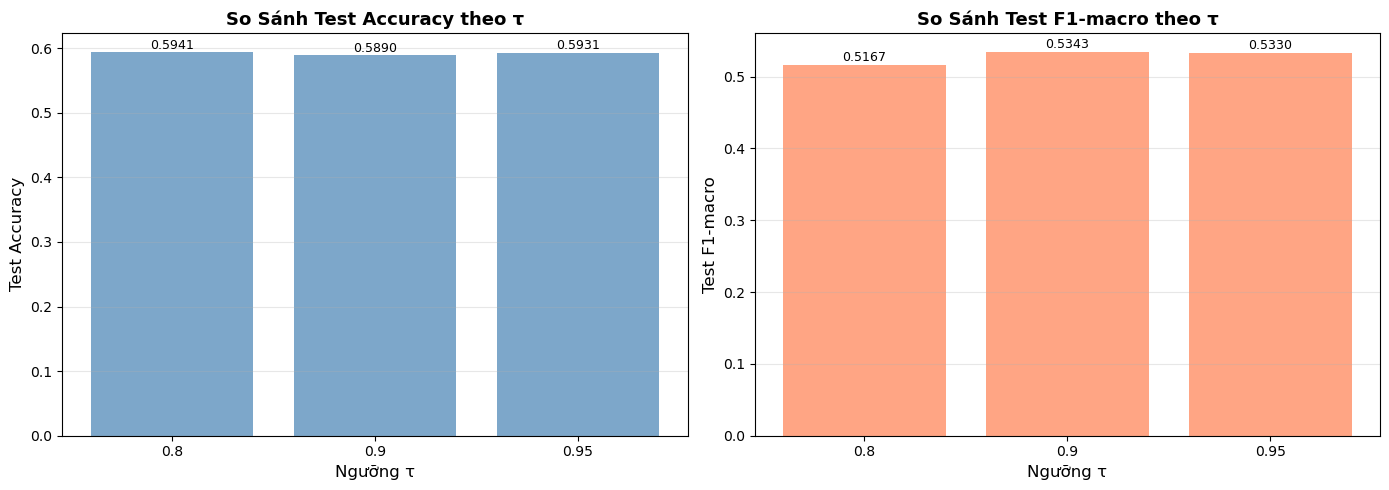

✓ Saved: D:\DataEngineer\DataMining\air_guard_mini_project\data\processed\self_training_experiments\test_performance_comparison.png


In [7]:
# Plot test performance comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy
axes[0].bar(comparison_df["TAU (τ)"].astype(str), comparison_df["Test Accuracy"], color='steelblue', alpha=0.7)
axes[0].set_xlabel("Ngưỡng τ", fontsize=12)
axes[0].set_ylabel("Test Accuracy", fontsize=12)
axes[0].set_title("So Sánh Test Accuracy theo τ", fontsize=13, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(comparison_df["Test Accuracy"]):
    axes[0].text(i, v + 0.005, f"{v:.4f}", ha='center', fontsize=9)

# F1-macro
axes[1].bar(comparison_df["TAU (τ)"].astype(str), comparison_df["Test F1-macro"], color='coral', alpha=0.7)
axes[1].set_xlabel("Ngưỡng τ", fontsize=12)
axes[1].set_ylabel("Test F1-macro", fontsize=12)
axes[1].set_title("So Sánh Test F1-macro theo τ", fontsize=13, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)
for i, v in enumerate(comparison_df["Test F1-macro"]):
    axes[1].text(i, v + 0.005, f"{v:.4f}", ha='center', fontsize=9)

plt.tight_layout()
plt.savefig(results_dir / "test_performance_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Saved: {results_dir / 'test_performance_comparison.png'}")

## Bước 5: Visualize - Diễn Biến Số Pseudo-Labels Qua Các Vòng

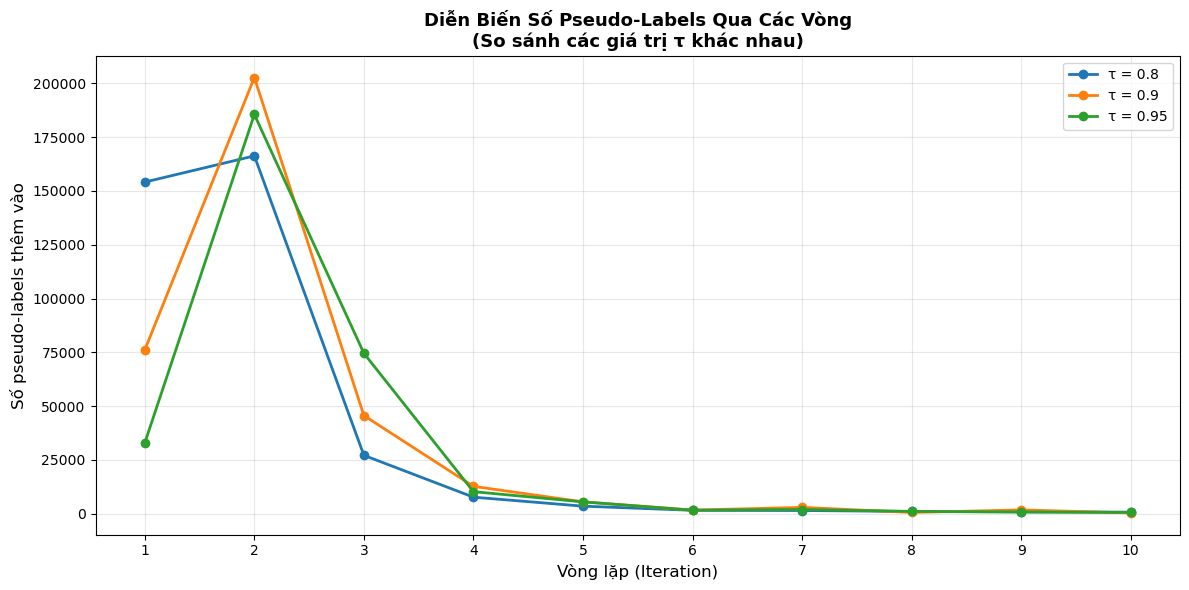

✓ Saved: D:\DataEngineer\DataMining\air_guard_mini_project\data\processed\self_training_experiments\pseudo_labels_over_iterations.png


In [8]:
# Plot pseudo-labels over iterations
fig, ax = plt.subplots(figsize=(12, 6))

for tau in TAU_VALUES:
    history = all_results[tau]["history"]
    ax.plot(history["iter"], history["new_pseudo"], marker='o', label=f"τ = {tau}", linewidth=2)

ax.set_xlabel("Vòng lặp (Iteration)", fontsize=12)
ax.set_ylabel("Số pseudo-labels thêm vào", fontsize=12)
ax.set_title("Diễn Biến Số Pseudo-Labels Qua Các Vòng\n(So sánh các giá trị τ khác nhau)", 
             fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xticks(range(1, MAX_ITER + 1))

plt.tight_layout()
plt.savefig(results_dir / "pseudo_labels_over_iterations.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Saved: {results_dir / 'pseudo_labels_over_iterations.png'}")

## Bước 6: Visualize - Validation F1-macro Qua Các Vòng

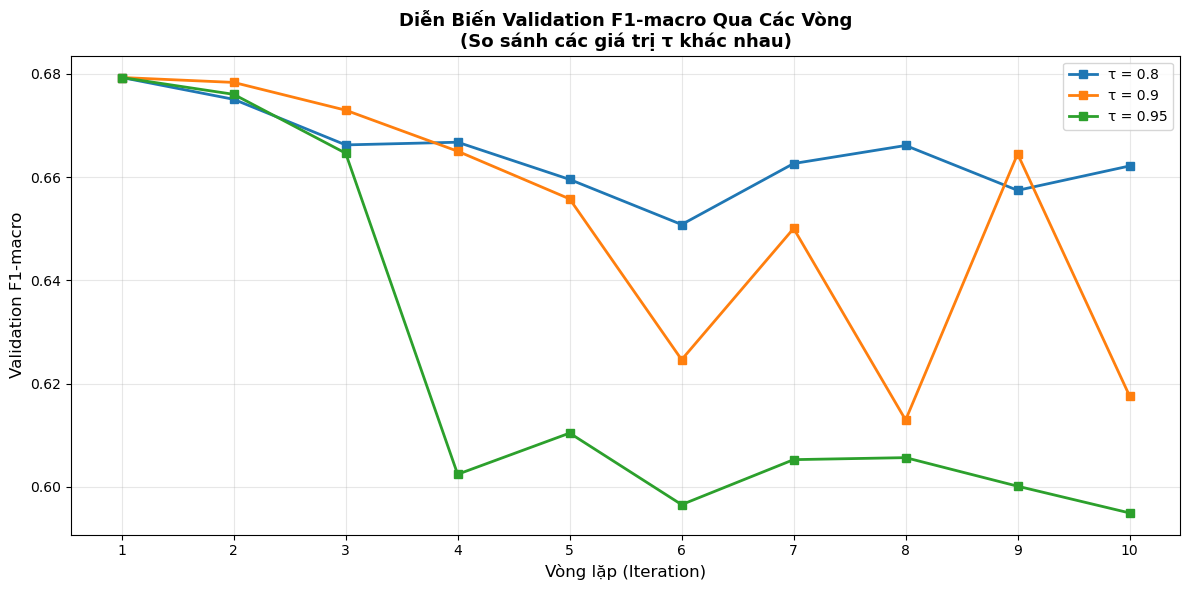

✓ Saved: D:\DataEngineer\DataMining\air_guard_mini_project\data\processed\self_training_experiments\validation_f1_over_iterations.png


In [9]:
# Plot validation F1-macro over iterations
fig, ax = plt.subplots(figsize=(12, 6))

for tau in TAU_VALUES:
    history = all_results[tau]["history"]
    ax.plot(history["iter"], history["val_f1_macro"], marker='s', label=f"τ = {tau}", linewidth=2)

ax.set_xlabel("Vòng lặp (Iteration)", fontsize=12)
ax.set_ylabel("Validation F1-macro", fontsize=12)
ax.set_title("Diễn Biến Validation F1-macro Qua Các Vòng\n(So sánh các giá trị τ khác nhau)", 
             fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xticks(range(1, MAX_ITER + 1))

plt.tight_layout()
plt.savefig(results_dir / "validation_f1_over_iterations.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Saved: {results_dir / 'validation_f1_over_iterations.png'}")

## Bước 7: Phân Tích Chi Tiết Từng τ

In [10]:
for tau in TAU_VALUES:
    print(f"\n{'='*80}")
    print(f"PHÂN TÍCH CHI TIẾT: TAU = {tau}")
    print(f"{'='*80}")
    
    history = all_results[tau]["history"]
    metrics = all_results[tau]["test_metrics"]
    
    print("\n📊 Diễn biến qua các vòng:")
    display(history)
    
    # Observations
    print("\n🔍 NHẬN XÉT:")
    
    # 1. Vòng đầu thêm bao nhiêu?
    first_iter_pseudo = history["new_pseudo"].iloc[0]
    print(f"\n1. Vòng đầu tiên:")
    print(f"   - Thêm được {first_iter_pseudo} pseudo-labels")
    if first_iter_pseudo > 1000:
        print(f"   ⚠️ Số lượng RẤT NHIỀU → Model quá tự tin hoặc gặp nhiều mẫu dễ")
    elif first_iter_pseudo > 500:
        print(f"   ✓ Số lượng VỪA PHẢI → Model có độ tin cậy tốt")
    else:
        print(f"   ⚠️ Số lượng ÍT → Model thận trọng quá hoặc τ quá cao")
    
    # 2. Xu hướng tăng/giảm
    print(f"\n2. Xu hướng số pseudo-labels:")
    if len(history) > 2:
        trend = history["new_pseudo"].diff().iloc[1:]
        if (trend < 0).all():
            print(f"   ↓ GIẢM DẦN qua các vòng → Bình thường (hết mẫu dễ)")
        elif (trend > 0).any():
            print(f"   ↑ CÓ VÒNG TĂNG → Model học tốt hơn, tự tin hơn")
        else:
            print(f"   → ỔN ĐỊNH")
    
    # 3. Validation F1 có giảm không?
    print(f"\n3. Validation F1-macro:")
    val_f1_diff = history["val_f1_macro"].diff()
    decrease_iters = history[val_f1_diff < -0.01]["iter"].tolist()
    
    if decrease_iters:
        print(f"   ⚠️ GIẢM ở vòng: {decrease_iters}")
        print(f"   → Nguyên nhân: Model có thể đã thêm nhãn SAI và học theo chúng")
        print(f"   → Cân nhắc DỪNG SỚM ở vòng {decrease_iters[0] - 1}")
    else:
        print(f"   ✓ TĂNG hoặc ỔN ĐỊNH qua các vòng")
        print(f"   → Model học tốt, không bị overfitting")
    
    # 4. Test performance
    print(f"\n4. Kết quả trên Test set:")
    print(f"   - Test Accuracy: {metrics['accuracy']:.4f}")
    print(f"   - Test F1-macro: {metrics['f1_macro']:.4f}")
    print(f"   - Số vòng lặp: {len(history)}")
    print(f"   - Tổng pseudo-labels: {history['new_pseudo'].sum()}")


PHÂN TÍCH CHI TIẾT: TAU = 0.8

📊 Diễn biến qua các vòng:


,iter,val_accuracy,val_f1_macro,unlabeled_pool,new_pseudo,tau
0,1,0.722615,0.679270,383962,154115,0.8
1,2,0.708228,0.675047,229847,166298,0.8
2,3,0.701918,0.666222,63549,27129,0.8
3,4,0.703180,0.666744,36420,7686,0.8
4,5,0.699142,0.659539,28734,3512,0.8
5,6,0.690560,0.650806,25222,1575,0.8
6,7,0.700151,0.662619,23647,1487,0.8
7,8,0.700404,0.666110,22160,1041,0.8
8,9,0.695103,0.657425,21119,823,0.8
9,10,0.697627,0.662147,20296,722,0.8



🔍 NHẬN XÉT:

1. Vòng đầu tiên:
   - Thêm được 154115 pseudo-labels
   ⚠️ Số lượng RẤT NHIỀU → Model quá tự tin hoặc gặp nhiều mẫu dễ

2. Xu hướng số pseudo-labels:
   ↑ CÓ VÒNG TĂNG → Model học tốt hơn, tự tin hơn

3. Validation F1-macro:
   ✓ TĂNG hoặc ỔN ĐỊNH qua các vòng
   → Model học tốt, không bị overfitting

4. Kết quả trên Test set:
   - Test Accuracy: 0.5941
   - Test F1-macro: 0.5167
   - Số vòng lặp: 10
   - Tổng pseudo-labels: 364388

PHÂN TÍCH CHI TIẾT: TAU = 0.9

📊 Diễn biến qua các vòng:


,iter,val_accuracy,val_f1_macro,unlabeled_pool,new_pseudo,tau
0,1,0.722615,0.679270,383962,76134,0.9
1,2,0.713781,0.678319,307828,202713,0.9
2,3,0.706461,0.672945,105115,45622,0.9
3,4,0.700151,0.665001,59493,12716,0.9
4,5,0.695356,0.655768,46777,5519,0.9
5,6,0.670116,0.624643,41258,1660,0.9
6,7,0.690056,0.650048,39598,2953,0.9
7,8,0.663806,0.612969,36645,587,0.9
8,9,0.701161,0.664477,36058,1762,0.9
9,10,0.666835,0.617609,34296,353,0.9



🔍 NHẬN XÉT:

1. Vòng đầu tiên:
   - Thêm được 76134 pseudo-labels
   ⚠️ Số lượng RẤT NHIỀU → Model quá tự tin hoặc gặp nhiều mẫu dễ

2. Xu hướng số pseudo-labels:
   ↑ CÓ VÒNG TĂNG → Model học tốt hơn, tự tin hơn

3. Validation F1-macro:
   ⚠️ GIẢM ở vòng: [6, 8, 10]
   → Nguyên nhân: Model có thể đã thêm nhãn SAI và học theo chúng
   → Cân nhắc DỪNG SỚM ở vòng 5

4. Kết quả trên Test set:
   - Test Accuracy: 0.5890
   - Test F1-macro: 0.5343
   - Số vòng lặp: 10
   - Tổng pseudo-labels: 350019

PHÂN TÍCH CHI TIẾT: TAU = 0.95

📊 Diễn biến qua các vòng:


,iter,val_accuracy,val_f1_macro,unlabeled_pool,new_pseudo,tau
0,1,0.722615,0.679270,383962,32943,0.95
1,2,0.718576,0.676012,351019,185529,0.95
2,3,0.708481,0.664617,165490,74534,0.95
3,4,0.650934,0.602460,90956,10241,0.95
4,5,0.659263,0.610434,80715,5497,0.95
5,6,0.648410,0.596585,75218,1656,0.95
6,7,0.656991,0.605293,73562,1947,0.95
7,8,0.651691,0.605680,71615,1071,0.95
8,9,0.650681,0.600152,70544,827,0.95
9,10,0.646138,0.594974,69717,589,0.95



🔍 NHẬN XÉT:

1. Vòng đầu tiên:
   - Thêm được 32943 pseudo-labels
   ⚠️ Số lượng RẤT NHIỀU → Model quá tự tin hoặc gặp nhiều mẫu dễ

2. Xu hướng số pseudo-labels:
   ↑ CÓ VÒNG TĂNG → Model học tốt hơn, tự tin hơn

3. Validation F1-macro:
   ⚠️ GIẢM ở vòng: [3, 4, 6]
   → Nguyên nhân: Model có thể đã thêm nhãn SAI và học theo chúng
   → Cân nhắc DỪNG SỚM ở vòng 2

4. Kết quả trên Test set:
   - Test Accuracy: 0.5931
   - Test F1-macro: 0.5330
   - Số vòng lặp: 10
   - Tổng pseudo-labels: 314834


## Bước 8: Load Baseline và So Sánh

In [11]:
# Load baseline metrics
baseline_path = PROJECT_ROOT / "data/processed/metrics.json"

if baseline_path.exists():
    with open(baseline_path, "r", encoding="utf-8") as f:
        baseline_metrics = json.load(f)
    
    baseline_acc = baseline_metrics.get("accuracy", None)
    baseline_f1 = baseline_metrics.get("f1_macro", None)
    
    print("\n" + "="*80)
    print("SO SÁNH VỚI BASELINE SUPERVISED (100% labels)")
    print("="*80)
    
    print(f"\nBaseline (Supervised với 100% labels):")
    print(f"  - Accuracy: {baseline_acc:.4f}")
    print(f"  - F1-macro: {baseline_f1:.4f}")
    
    print("\n" + "-"*80)
    print("Self-Training Results (chỉ dùng 5% labels ban đầu):")
    print("-"*80)
    
    for tau in TAU_VALUES:
        metrics = all_results[tau]["test_metrics"]
        acc = metrics["accuracy"]
        f1 = metrics["f1_macro"]
        
        acc_diff = acc - baseline_acc
        f1_diff = f1 - baseline_f1
        
        print(f"\nτ = {tau}:")
        print(f"  - Accuracy: {acc:.4f} ({acc_diff:+.4f}) {'✓' if acc_diff >= 0 else '↓'}")
        print(f"  - F1-macro: {f1:.4f} ({f1_diff:+.4f}) {'✓' if f1_diff >= 0 else '↓'}")
        
        if acc_diff >= -0.02:
            print(f"  💡 Self-training ĐẠT GẦN baseline mặc dù chỉ dùng 5% labels!")
        elif acc_diff < -0.05:
            print(f"  ⚠️ Chênh lệch lớn → Cần điều chỉnh τ hoặc tăng labeled data")
    
    # Plot comparison with baseline
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Accuracy comparison
    x_pos = np.arange(len(TAU_VALUES) + 1)
    acc_values = [baseline_acc] + [all_results[tau]["test_metrics"]["accuracy"] for tau in TAU_VALUES]
    labels = ["Baseline\n(100%)"  ] + [f"τ={tau}\n(5%)" for tau in TAU_VALUES]
    colors = ['gold'] + ['steelblue'] * len(TAU_VALUES)
    
    axes[0].bar(x_pos, acc_values, color=colors, alpha=0.7, edgecolor='black')
    axes[0].set_xticks(x_pos)
    axes[0].set_xticklabels(labels)
    axes[0].set_ylabel("Test Accuracy", fontsize=12)
    axes[0].set_title("So Sánh Accuracy: Baseline vs Self-Training", fontsize=13, fontweight='bold')
    axes[0].grid(axis='y', alpha=0.3)
    axes[0].axhline(y=baseline_acc, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Baseline')
    for i, v in enumerate(acc_values):
        axes[0].text(i, v + 0.005, f"{v:.4f}", ha='center', fontsize=9)
    
    # F1-macro comparison
    f1_values = [baseline_f1] + [all_results[tau]["test_metrics"]["f1_macro"] for tau in TAU_VALUES]
    
    axes[1].bar(x_pos, f1_values, color=colors, alpha=0.7, edgecolor='black')
    axes[1].set_xticks(x_pos)
    axes[1].set_xticklabels(labels)
    axes[1].set_ylabel("Test F1-macro", fontsize=12)
    axes[1].set_title("So Sánh F1-macro: Baseline vs Self-Training", fontsize=13, fontweight='bold')
    axes[1].grid(axis='y', alpha=0.3)
    axes[1].axhline(y=baseline_f1, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Baseline')
    for i, v in enumerate(f1_values):
        axes[1].text(i, v + 0.005, f"{v:.4f}", ha='center', fontsize=9)
    
    plt.tight_layout()
    plt.savefig(results_dir / "comparison_with_baseline.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\n✓ Saved: {results_dir / 'comparison_with_baseline.png'}")
    
else:
    print(f"\n⚠️ Baseline metrics not found at: {baseline_path}")
    print("Run classification_modelling.ipynb first to generate baseline.")


⚠️ Baseline metrics not found at: D:\DataEngineer\DataMining\air_guard_mini_project\data\processed\metrics.json
Run classification_modelling.ipynb first to generate baseline.


## Bước 9: Phân Tích Per-Class Performance (Lớp nào được hưởng lợi?)

In [12]:
# Chọn tau tốt nhất để phân tích chi tiết
best_tau = comparison_df.loc[comparison_df["Test F1-macro"].idxmax(), "TAU (τ)"]

print(f"\n{'='*80}")
print(f"PHÂN TÍCH CHI TIẾT THEO LỚP - TAU TỐI ƯU: {best_tau}")
print(f"{'='*80}")

metrics = all_results[best_tau]["test_metrics"]
report = metrics["report"]

# Extract per-class metrics
class_metrics = []
for class_name in metrics["labels"]:
    if class_name in report:
        class_metrics.append({
            "Class": class_name,
            "Precision": report[class_name]["precision"],
            "Recall": report[class_name]["recall"],
            "F1-score": report[class_name]["f1-score"],
            "Support": report[class_name]["support"],
        })

class_df = pd.DataFrame(class_metrics)
display(class_df)

# Compare with baseline if available
if baseline_path.exists():
    baseline_report = baseline_metrics.get("report", {})
    
    if baseline_report:
        print("\n" + "-"*80)
        print("SO SÁNH VỚI BASELINE THEO TỪNG LỚP:")
        print("-"*80)
        
        comparison_class = []
        for class_name in metrics["labels"]:
            if class_name in report and class_name in baseline_report:
                st_f1 = report[class_name]["f1-score"]
                bl_f1 = baseline_report[class_name]["f1-score"]
                diff = st_f1 - bl_f1
                
                comparison_class.append({
                    "Class": class_name,
                    "Baseline F1": bl_f1,
                    "Self-Train F1": st_f1,
                    "Chênh lệch": diff,
                    "Trạng thái": "✓ Cải thiện" if diff > 0.01 else ("↓ Giảm" if diff < -0.01 else "≈ Tương đương"),
                })
        
        comp_class_df = pd.DataFrame(comparison_class)
        display(comp_class_df)
        
        # Plot
        fig, ax = plt.subplots(figsize=(12, 6))
        
        x = np.arange(len(comp_class_df))
        width = 0.35
        
        ax.bar(x - width/2, comp_class_df["Baseline F1"], width, label='Baseline', alpha=0.7, color='gold')
        ax.bar(x + width/2, comp_class_df["Self-Train F1"], width, label=f'Self-Training (τ={best_tau})', alpha=0.7, color='steelblue')
        
        ax.set_xlabel("AQI Class", fontsize=12)
        ax.set_ylabel("F1-score", fontsize=12)
        ax.set_title(f"So Sánh F1-score Theo Từng Lớp\nBaseline vs Self-Training (τ={best_tau})", fontsize=13, fontweight='bold')
        ax.set_xticks(x)
        ax.set_xticklabels(comp_class_df["Class"], rotation=45, ha='right')
        ax.legend()
        ax.grid(axis='y', alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(results_dir / "per_class_comparison.png", dpi=300, bbox_inches='tight')
        plt.show()
        
        print(f"\n✓ Saved: {results_dir / 'per_class_comparison.png'}")
        
        # Identify benefited classes
        print("\n🎯 NHẬN XÉT:")
        improved = comp_class_df[comp_class_df["Chênh lệch"] > 0.01]
        degraded = comp_class_df[comp_class_df["Chênh lệch"] < -0.01]
        
        if not improved.empty:
            print(f"\n✓ Các lớp ĐƯỢC CẢI THIỆN:")
            for _, row in improved.iterrows():
                print(f"  - {row['Class']}: +{row['Chênh lệch']:.4f}")
        
        if not degraded.empty:
            print(f"\n↓ Các lớp BỊ GIẢM:")
            for _, row in degraded.iterrows():
                print(f"  - {row['Class']}: {row['Chênh lệch']:.4f}")

# Save final comparison
final_comparison_path = results_dir / "per_class_comparison.csv"
if 'comp_class_df' in locals():
    comp_class_df.to_csv(final_comparison_path, index=False)
    print(f"\n✓ Saved: {final_comparison_path}")


PHÂN TÍCH CHI TIẾT THEO LỚP - TAU TỐI ƯU: 0.9


,Class,Precision,Recall,F1-score,Support
0,Good,0.653722,0.391473,0.489697,1032.0
1,Moderate,0.605961,0.841299,0.704496,4833.0
2,Unhealthy_for_Sensitive_Groups,0.265938,0.134811,0.178922,2166.0
3,Unhealthy,0.596491,0.579095,0.587664,4286.0
4,Very_Unhealthy,0.551220,0.587835,0.568939,2499.0
5,Hazardous,0.780127,0.596765,0.676237,1855.0


## Bước 10: Kết Luận và Khuyến Nghị

In [13]:
print("\n" + "="*80)
print("KẾT LUẬN VÀ KHUYẾN NGHỊ")
print("="*80)

best_f1_tau = comparison_df.loc[comparison_df["Test F1-macro"].idxmax(), "TAU (τ)"]
best_f1_value = comparison_df["Test F1-macro"].max()

print(f"\n1️⃣ NGƯỠNG τ TỐI ƯU: {best_f1_tau}")
print(f"   - Đạt Test F1-macro: {best_f1_value:.4f}")
print(f"   - Số vòng lặp: {comparison_df[comparison_df['TAU (τ)'] == best_f1_tau]['Số vòng lặp'].values[0]}")

print(f"\n2️⃣ SO SÁNH VỚI BASELINE:")
if baseline_path.exists():
    diff_from_baseline = best_f1_value - baseline_f1
    if diff_from_baseline >= -0.02:
        print(f"   ✅ Self-training ĐẠT THÀNH CÔNG!")
        print(f"   - Chỉ dùng 5% labels nhưng đạt {best_f1_value:.4f}")
        print(f"   - So với baseline (100% labels): {diff_from_baseline:+.4f}")
    else:
        print(f"   ⚠️ Còn khoảng cách với baseline: {diff_from_baseline:.4f}")
        print(f"   - Cần xem xét tăng labeled data hoặc điều chỉnh tham số")

print(f"\n3️⃣ TẤT CẢ KẾT QUẢ ĐÃ LƯU TẠI:")
print(f"   📁 {results_dir}")
print(f"   - Metrics JSON cho mỗi τ")
print(f"   - Predictions CSV")
print(f"   - Biểu đồ so sánh")
print(f"   - Bảng tổng hợp")

print(f"\n4️⃣ BƯỚC TIẾP THEO:")
print(f"   → Chạy Co-Training với τ = {best_f1_tau}")
print(f"   → So sánh Self-Training vs Co-Training")
print(f"   → Viết báo cáo chi tiết với các biểu đồ đã tạo")

print("\n" + "="*80)


KẾT LUẬN VÀ KHUYẾN NGHỊ

1️⃣ NGƯỠNG τ TỐI ƯU: 0.9
   - Đạt Test F1-macro: 0.5343
   - Số vòng lặp: 10

2️⃣ SO SÁNH VỚI BASELINE:



3️⃣ TẤT CẢ KẾT QUẢ ĐÃ LƯU TẠI:
   📁 D:\DataEngineer\DataMining\air_guard_mini_project\data\processed\self_training_experiments
   - Metrics JSON cho mỗi τ
   - Predictions CSV
   - Biểu đồ so sánh
   - Bảng tổng hợp

4️⃣ BƯỚC TIẾP THEO:
   → Chạy Co-Training với τ = 0.9
   → So sánh Self-Training vs Co-Training
   → Viết báo cáo chi tiết với các biểu đồ đã tạo

